* I have divided the dataset into training, testing for SVM and XGBoost models using train_test_split() test:30% and traning:70%

* I have used feature normalization to use PCA and for some methods that preform better without PCA

* I have used PCA to visualize the data and for some methods that preforme better with it

In [1]:
! pip install fuzzy-c-means
! pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from fcmeans import FCM
from matplotlib.colors import ListedColormap
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
%matplotlib inline
sns.set_style('whitegrid')



In [3]:
df= pd.read_csv("Breast Cancer Data.csv")

In [4]:
df.head()

,Classes,Average Mean,Texture Average,Average Perimeter,Average Area,Average Smoothness,Average Compactnes,Average Concavity,Average Concavity 2,Average Symmetry,...,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Compactness,Worst Concavity,Worst Concavity X,Worst Symmetry,Worst Fractal Dim
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Let's check if there is duplicated or null values

In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Classes                0
Average Mean           0
Texture Average        0
Average Perimeter      0
Average Area           0
Average Smoothness     0
Average Compactnes     0
Average Concavity      0
Average Concavity 2    0
Average Symmetry       0
Average Fractal Dim    0
Radius                 0
Texture                0
Perimeter              0
Area                   0
Smoothness             0
Compactness            0
Concavity              0
Concavity X            0
Symmetry X             0
Fractal Dimension X    0
Worst Radius           0
Worst Texture          0
Worst Perimeter        0
Worst Area             0
Worst Smoothness       0
Worst Compactness      0
Worst Concavity        0
Worst Concavity X      0
Worst Symmetry         0
Worst Fractal Dim      0
dtype: int64

No missing values and no repeated values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Classes              569 non-null    object 
 1   Average Mean         569 non-null    float64
 2   Texture Average      569 non-null    float64
 3   Average Perimeter    569 non-null    float64
 4   Average Area         569 non-null    float64
 5   Average Smoothness   569 non-null    float64
 6   Average Compactnes   569 non-null    float64
 7   Average Concavity    569 non-null    float64
 8   Average Concavity 2  569 non-null    float64
 9   Average Symmetry     569 non-null    float64
 10  Average Fractal Dim  569 non-null    float64
 11  Radius               569 non-null    float64
 12  Texture              569 non-null    float64
 13  Perimeter            569 non-null    float64
 14  Area                 569 non-null    float64
 15  Smoothness           569 non-null    flo

In [8]:
#As we see here we have only 'Classes' coulmn that is not numeric
df['Classes'].unique()

array(['M', 'B'], dtype=object)

In [9]:
#Converting 'Classes' column to numeric column
df['Classes'].replace(['M', 'B'],[0, 1], inplace=True)

In [10]:
#Setting X without 'Classes' column
X = df.drop('Classes', axis=1)
# normalizing the features
X_normalized = StandardScaler().fit_transform(X) 
#Setting y as 'Classes' which is our target
y = df['Classes']

In [11]:
#Using PCA with 2 components and fit it with the normalized data
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_normalized)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [12]:
#Function to plot the support vectors for SVM models
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [13]:
#Form 30D to 2D by PCA
principalDf

,principal component 1,principal component 2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072
...,...,...
564,6.439315,-3.576817
565,3.793382,-3.584048
566,1.256179,-1.902297
567,10.374794,1.672010


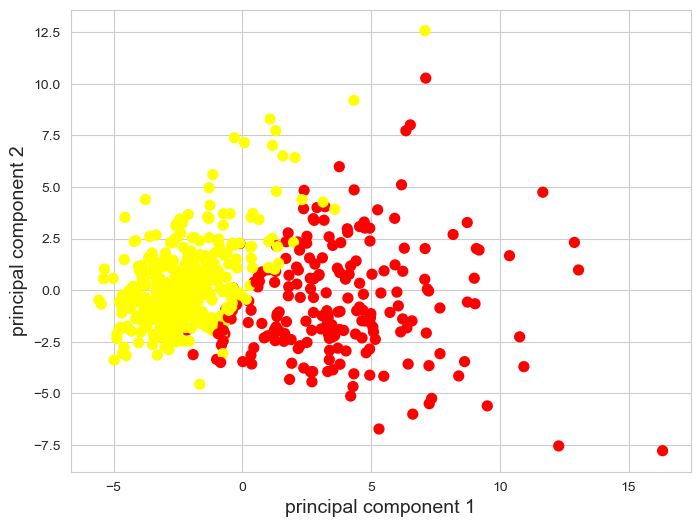

In [14]:
#Plot of the PCA data
fig, ax = plt.subplots(figsize=(8, 6))
X1=principalDf['principal component 1']
X2=principalDf['principal component 2']
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
import seaborn as sns; sns.set()
plt.scatter(X1, X2, c=y, s=50, cmap='autumn');


# 1-SVM & Backpropagation neural network

In [15]:
#Splitting the data into traning and testing 
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.3, random_state=42)
print(len(X_train))
print(len(X_test))

398
171


# SVM

# Linear kernel

In [16]:
#SVM with linear kernel
model = SVC(kernel='linear')
svc=model.fit(X_train, y_train)
predictions = model.predict(X_test)

percentage = model.score(X_test, y_test)

res = confusion_matrix(y_test, predictions)
print("Confusion Matrix")
print(res)
print(f"Accuracy = {percentage*100} %")
print('f1 score =',f1_score(y_test, predictions)*100 , '%')

Confusion Matrix
[[ 60   3]
 [  2 106]]
Accuracy = 97.07602339181285 %
f1 score = 97.69585253456222 %


C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


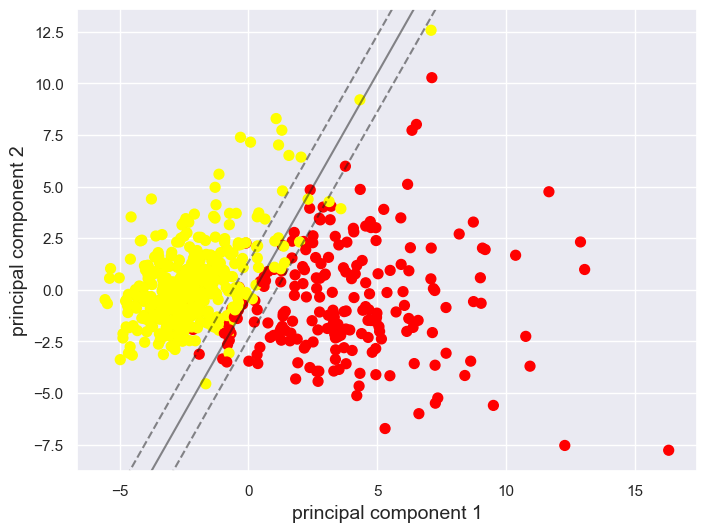

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
plt.scatter(X1, X2, c=y, s=50,cmap='autumn')
plot_svc_decision_function(svc);

# Gaussain rbf kernel

In [18]:
#SVM with Gaussain rbf kernel
model = SVC(kernel='rbf', gamma=0.5, C=0.1)
rbf_svc=model.fit(X_train, y_train)
predictions = model.predict(X_test)

percentage = model.score(X_test, y_test)

res = confusion_matrix(y_test, predictions)
print("Confusion Matrix")
print(res)
print(f"Accuracy = {percentage*100} %")
print('f1 score =',f1_score(y_test, predictions)*100 , '%')

Confusion Matrix
[[ 58   5]
 [  5 103]]
Accuracy = 94.15204678362574 %
f1 score = 95.37037037037037 %


C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


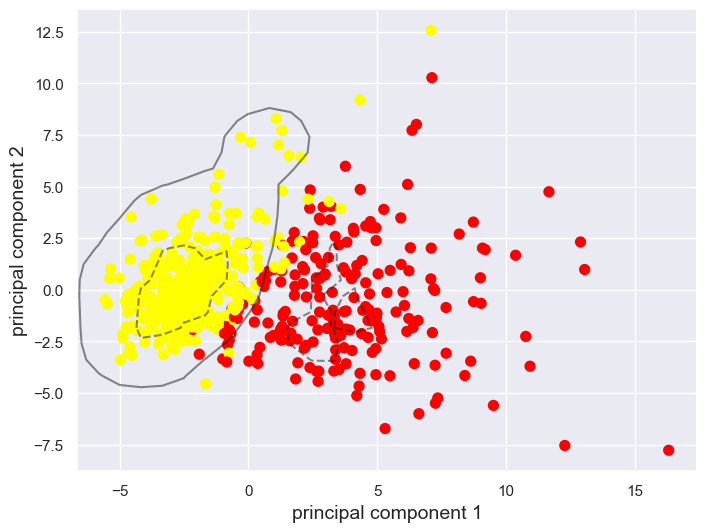

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
plt.scatter(X1, X2, c=y, s=50,cmap='autumn')
plot_svc_decision_function(rbf_svc);

# polynomial kernel with degree 2

In [20]:
#SVM with polynomial kernel with degree 2
model = SVC(kernel='poly', degree=2, gamma='auto', coef0=1, C=5) 
poly_svc=model.fit(X_train, y_train)
predictions = model.predict(X_test)

percentage = model.score(X_test, y_test)

res = confusion_matrix(y_test, predictions)
print("Confusion Matrix")
print(res)
print(f"Accuracy = {percentage*100} %")
print('f1 score =',f1_score(y_test, predictions)*100, '%')

Confusion Matrix
[[ 59   4]
 [  2 106]]
Accuracy = 96.49122807017544 %
f1 score = 97.24770642201834 %


C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


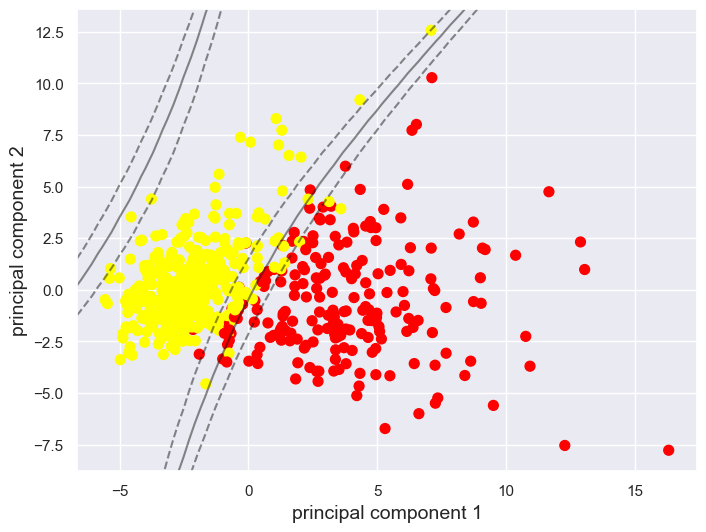

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
plt.scatter(X1, X2, c=y, s=50,cmap='autumn')
plot_svc_decision_function(poly_svc);

# Backpropagation neural network

In [22]:
from sklearn.neural_network import MLPClassifier
#Spliting the normalized data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)
#initalize the neural network 
model=MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000, random_state=69)
#Fitting the model
model.fit(X_train,y_train)
#Predicting
model_predictions=model.predict(X_test)
precentage = accuracy_score(model_predictions, y_test)
res = confusion_matrix(model_predictions, y_test)
print("Confusion Matrix")
print(res)

print("Accuracy: {}".format(precentage*100),'%')
print('f1 score:',f1_score(model_predictions, y_test)*100,'%')

Confusion Matrix
[[ 61   1]
 [  2 107]]
Accuracy: 98.24561403508771 %
f1 score: 98.61751152073732 %


# 2-  K-means 

Plot of data without labels

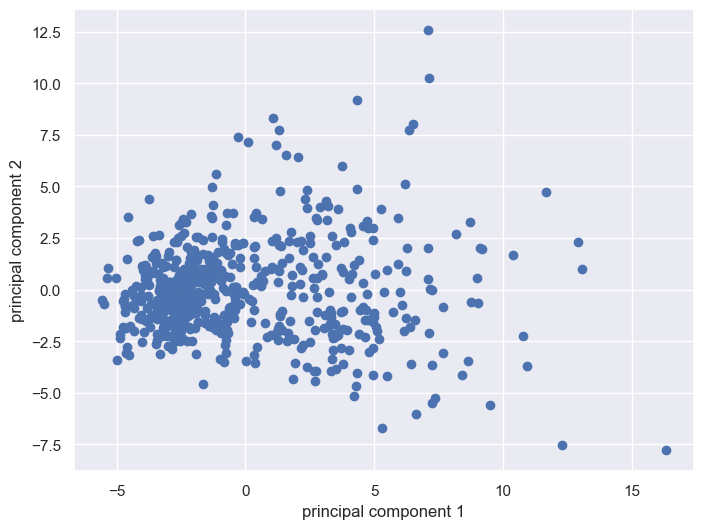

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.title('')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

In [24]:
#Kmeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=100)

Let's try to fit K-means without PCA

In [25]:
kmeans.fit(X)
acc = accuracy_score(kmeans.labels_, y)
res = confusion_matrix(kmeans.labels_, y)
print("Confusion Matrix")
print(res)

print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(kmeans.labels_, y)*100,'%')

C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Confusion Matrix
[[ 82 356]
 [130   1]]
Accuracy: 14.586994727592268 %
f1 score: 0.4098360655737705 %


Very bad result, now let's fit it with PCA

In [26]:
kmeans.fit(principalDf)
acc = accuracy_score(kmeans.labels_, y)
res = confusion_matrix(kmeans.labels_, y)
print("Confusion Matrix")
print(res)

print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(kmeans.labels_, y)*100,'%')

C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Confusion Matrix
[[175  16]
 [ 37 341]]
Accuracy: 90.68541300527241 %
f1 score: 92.78911564625851 %


Very acceptable result and now we plot the data with k-means and its 2 centers

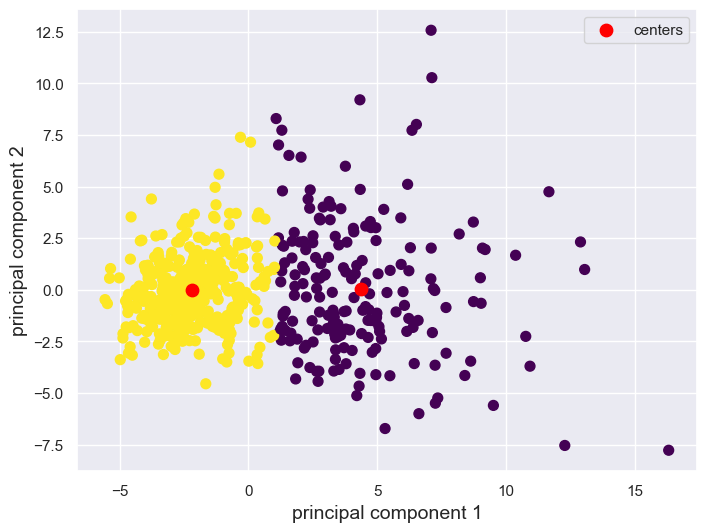

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=kmeans.predict(principalDf), s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red',label="centers", s=80, alpha=1);
leg = ax.legend();

# 3- fuzzy c-means

In [28]:
#Fuzzy c-means with 2 clusters
my_model = FCM(n_clusters=2, random_state=2)

We fit the model without PCA

In [29]:
my_model.fit(np.array(X)) 
hard_prediction_labels = my_model.predict(np.array(X))
acc = accuracy_score(hard_prediction_labels, y)
res = confusion_matrix(hard_prediction_labels, y)
print("Confusion Matrix")
print(res)

print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(hard_prediction_labels, y)*100,'%')

Confusion Matrix
[[130   1]
 [ 82 356]]
Accuracy: 85.41300527240774 %
f1 score: 89.55974842767296 %


Good result, but let's see the model with PCA

In [30]:
my_model.fit(np.array(principalDf)) 
hard_prediction_labels = my_model.predict(np.array(principalDf))
acc = accuracy_score(hard_prediction_labels, y)
res = confusion_matrix(hard_prediction_labels, y)
print("Confusion Matrix")
print(res)

print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(hard_prediction_labels, y)*100,'%')

Confusion Matrix
[[175  14]
 [ 37 343]]
Accuracy: 91.03690685413005 %
f1 score: 93.08005427408413 %


Better result with PCA and now we plot the data with Fuzzy c-means and its 2 centers

C:\Users\Hassan\AppData\Local\Temp\ipykernel_9296\481958898.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([cntrs[0][0],cntrs[1][0]], [cntrs[0][1],cntrs[1][1]],


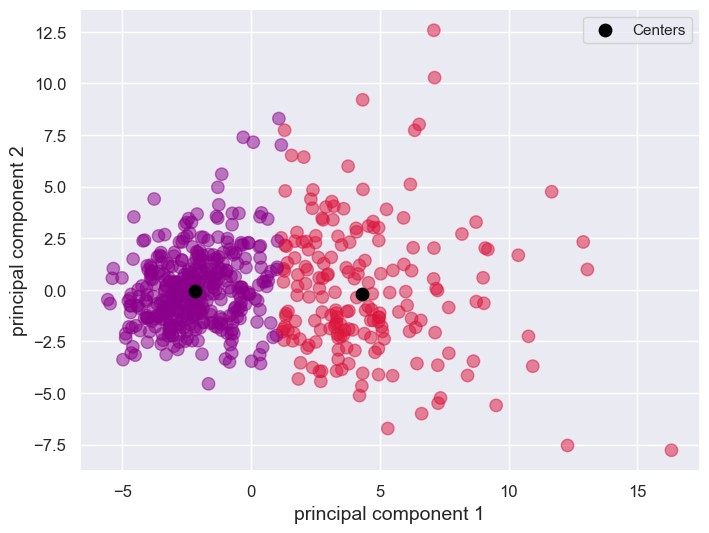

In [31]:
cntrs= my_model.centers

customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'],  principalDf['principal component 2'],  marker = 'o', 
            c=hard_prediction_labels, 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter([cntrs[0][0],cntrs[1][0]], [cntrs[0][1],cntrs[1][1]],  
            marker = 'o', s=80,
            c='black', label='Centers',cmap = customcmap)
ax.set_xlabel(r'principal component 1', fontsize=14)
ax.set_ylabel(r'principal component 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
leg = ax.legend();
plt.show()


# 4-Extract the “Average Mean” and “Texture Average” dimensions and plot the overlapped 2 clusters. Run both K-means and fuzzy c-means and compare the performance of the 2 algorithms.

In [32]:
#Extracting "Average Mean","Texture Average" from the data and save it in variable named Extracted
Extracted=df.loc[:,["Average Mean","Texture Average"]]
Extracted

,Average Mean,Texture Average
0,17.99,10.38
1,20.57,17.77
2,19.69,21.25
3,11.42,20.38
4,20.29,14.34
...,...,...
564,21.56,22.39
565,20.13,28.25
566,16.60,28.08
567,20.60,29.33


Plotting Average Mean vs Texture Average

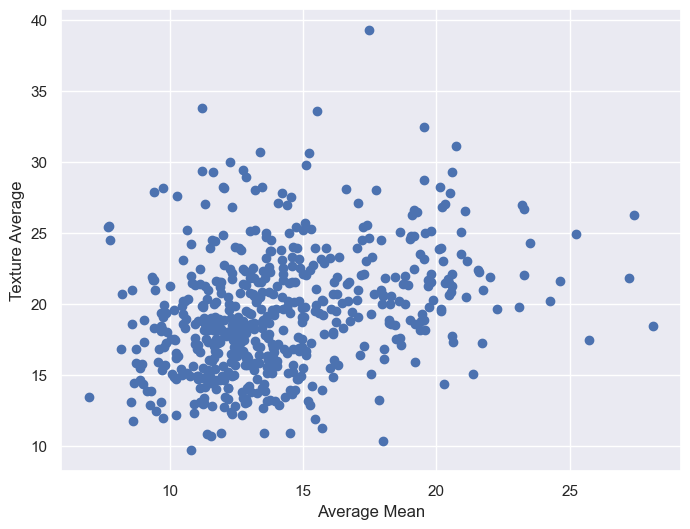

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df['Average Mean'], df['Texture Average'])
plt.title('')
plt.xlabel('Average Mean')
plt.ylabel('Texture Average')
plt.show()

In [34]:
#Normalizing the extracted data to use them in K-means and Fuzzy c-means
Extracted_normalized = StandardScaler().fit_transform(Extracted)

In [35]:
#Setting back feature names
feat_cols = ['feature'+str(i) for i in range(Extracted_normalized.shape[1])]
Extracted_normalized = pd.DataFrame(Extracted_normalized,columns=feat_cols)
Extracted_normalized.rename(columns = {'feature0':'Average Mean'}, inplace = True)
Extracted_normalized.rename(columns = {'feature1':'Texture Average'}, inplace = True)



In [36]:
Extracted_normalized

,Average Mean,Texture Average
0,1.097064,-2.073335
1,1.829821,-0.353632
2,1.579888,0.456187
3,-0.768909,0.253732
4,1.750297,-1.151816
...,...,...
564,2.110995,0.721473
565,1.704854,2.085134
566,0.702284,2.045574
567,1.838341,2.336457


# K-means

In [37]:
#K-means with 2 clusters
kmeans = KMeans(n_clusters=2,random_state=312)


Fitting the model with not normalized data

In [38]:
kmeans.fit(Extracted)
acc = accuracy_score(kmeans.labels_, y)
res = confusion_matrix(kmeans.labels_, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(kmeans.labels_, y)*100,'%')

C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Confusion Matrix
[[173  56]
 [ 39 301]]
Accuracy: 83.30404217926186 %
f1 score: 86.37015781922524 %


Fitting the model with normalized data

In [39]:
kmeans.fit(Extracted_normalized)
acc = accuracy_score(kmeans.labels_, y)
res = confusion_matrix(kmeans.labels_, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(kmeans.labels_, y)*100,'%')

C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Hassan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Confusion Matrix
[[172  38]
 [ 40 319]]
Accuracy: 86.29173989455184 %
f1 score: 89.10614525139665 %


Now we plot the data with k-means and its 2 centers

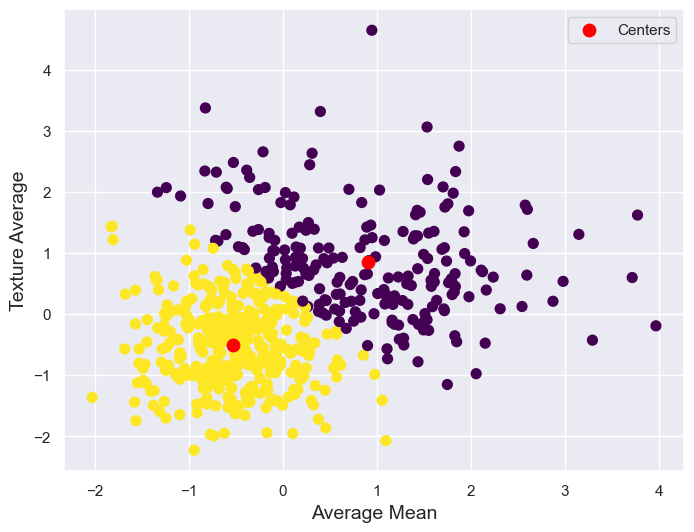

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r'Average Mean', fontsize=14)
ax.set_ylabel(r'Texture Average', fontsize=14)
plt.scatter(Extracted_normalized['Average Mean'], Extracted_normalized['Texture Average'], c=kmeans.predict(Extracted_normalized), s=50, cmap='viridis')

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red',label="Centers", s=80, alpha=1);
leg = ax.legend();

# Fuzzy c-means

In [41]:
#Fuzzy c-means with 2 clusters
my_model_FCM = FCM(n_clusters=2,random_state=547) 

Fitting the model with not normalized data

In [42]:
my_model_FCM.fit(np.array(Extracted)) 
hard_prediction_labels = my_model_FCM.predict(np.array(Extracted))
cntrs= my_model_FCM.centers
acc = accuracy_score(hard_prediction_labels, y)
res = confusion_matrix(hard_prediction_labels, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(hard_prediction_labels, y)*100,'%')

Confusion Matrix
[[174  56]
 [ 38 301]]
Accuracy: 83.47978910369068 %
f1 score: 86.49425287356321 %


Fitting the model with normalized data

In [43]:
my_model_FCM.fit(np.array(Extracted_normalized)) 
hard_prediction_labels = my_model_FCM.predict(np.array(Extracted_normalized))
cntrs= my_model_FCM.centers
acc = accuracy_score(hard_prediction_labels, y)
res = confusion_matrix(hard_prediction_labels, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(hard_prediction_labels, y)*100,'%')

Confusion Matrix
[[173  39]
 [ 39 318]]
Accuracy: 86.29173989455184 %
f1 score: 89.07563025210085 %


Now we plot the data with Fuzzy c-means and its 2 centers

C:\Users\Hassan\AppData\Local\Temp\ipykernel_9296\2192282852.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([cntrs[0][0],cntrs[1][0]], [cntrs[0][1],cntrs[1][1]],


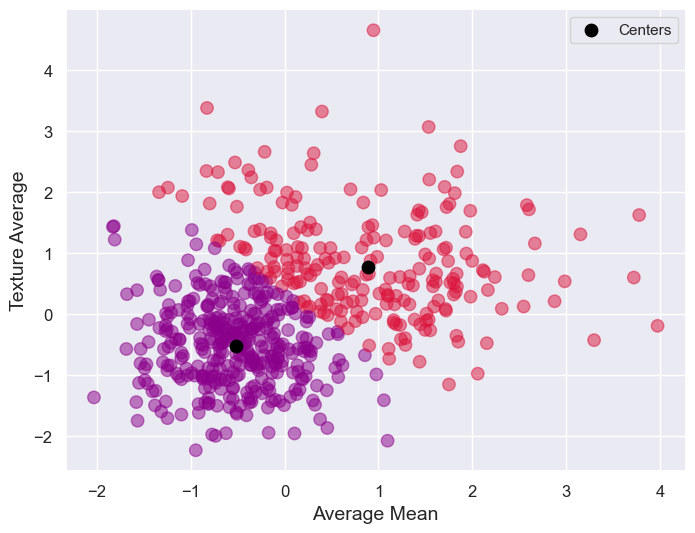

In [44]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(Extracted_normalized['Average Mean'], Extracted_normalized['Texture Average'],  marker = 'o', 
            c=hard_prediction_labels, 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter([cntrs[0][0],cntrs[1][0]], [cntrs[0][1],cntrs[1][1]],  
            marker = 'o', s=80,
            c='black', label='Centers',cmap = customcmap)
ax.set_xlabel(r'Average Mean', fontsize=14)
ax.set_ylabel(r'Texture Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
leg = ax.legend();
plt.show()

# Comparsion between K-means and fuzzy c-means 

Fitting the both models with normalized data is better

| Model | Accuracy | F1 score |
| --- | --- | --- |
|K-means|86.2917%|89.1061%
|Fuzzy c-means|86.2917%|89.0756%

The accuracy is the same for both models, while F1 score is very little larger in K-means model.

# 5-Comparing the result  of parts 1,2,3

| Model | Accuracy | F1 score |
| --- | --- | --- |
| SVM (Linear) | 97.0760 % | 97.6959 % |
|SVM (rbf)|94.1520%|95.3704%
|SVM (Ploynomial degree=2)|96.4912%|97.2477%
|BP neural network|98.2456 %|98.6175 % 
| K-means | 90.6854 %|92.7891 %
| fuzzy c-means | 91.0369 % |93.0801 %

Clearly, BP neural network is the best model for this data because it has the largest  accuracy &  F1 score 

SVM performs very well especially with linear kenel

Fuzzy c-means perform a little better than K-means 

PCA was used in all models except for BP neural network because the model gives high accuarcy without it so it wasn't needed

# 6-Extra models

# XGBoost model

In [45]:
from xgboost import XGBClassifier

In [46]:
#spliting the normlaized data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)
print(len(X_train))
print(len(X_test))

398
171


In [47]:
#Fitting the model using the normlaized data
model=XGBClassifier()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
percentage = model.score(X_test, y_test)
res = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(res)
print(f"Accuracy = {percentage*100} %")
print('f1 score =',f1_score(y_test, y_pred)*100 , '%')

Confusion Matrix
[[ 61   2]
 [  1 107]]
Accuracy = 98.24561403508771 %
f1 score = 98.61751152073732 %


In [48]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.3, random_state=42)


In [49]:
#Fitting the model using PCA
model=XGBClassifier()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [50]:
percentage = model.score(X_test, y_test)
res = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(res)
print(f"Accuracy = {percentage*100} %")
print('f1 score =',f1_score(y_test, y_pred)*100 , '%')

Confusion Matrix
[[ 60   3]
 [  4 104]]
Accuracy = 95.90643274853801 %
f1 score = 96.74418604651163 %


For this dataset, XGBoost model preform better without PCA

# Expectation-Maximization (EM) 

In [51]:
from sklearn import mixture

In [52]:
# expectation-maximization (EM) 
gmm = mixture.GaussianMixture(n_components=2, max_iter=100,init_params='random',random_state=85844)

Without feature scaling

In [53]:
gmm.fit(X)
yclust=gmm.predict(X)
acc = accuracy_score(yclust, y)
res = confusion_matrix(yclust, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(yclust, y)*100,'%')

Confusion Matrix
[[198  25]
 [ 14 332]]
Accuracy: 93.14586994727593 %
f1 score: 94.45234708392603 %


With feature scaling

In [54]:
gmm.fit(X_normalized)
yclust=gmm.predict(X_normalized)
acc = accuracy_score(yclust, y)
res = confusion_matrix(yclust, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(yclust, y)*100,'%')

Confusion Matrix
[[195  26]
 [ 17 331]]
Accuracy: 92.44288224956063 %
f1 score: 93.90070921985817 %


Using PCA

In [55]:
gmm.fit(principalDf)
yclust=gmm.predict(principalDf)
acc = accuracy_score(yclust, y)
res = confusion_matrix(yclust, y)
print("Confusion Matrix")
print(res)
print("Accuracy: {}".format(acc*100),'%')
print('f1 score:',f1_score(yclust, y)*100,'%')

Confusion Matrix
[[192  34]
 [ 20 323]]
Accuracy: 90.50966608084359 %
f1 score: 92.28571428571428 %


For this dataset, expectation-maximization (EM) preform better without PCA and without normlaized data

# Conclusion

| Model | Accuracy | F1 score |
| --- | --- | --- |
|XGBoost|98.2456%|98.6175%
|expectation-maximization|93.1459%|94.4523%

As can be seen from the table the decision tree(XGBoost) model preforme very well and better than expectation-maximization model

Running XGBoost with normalizing the data only is better than running it with PCA

Running expectation-maximization without PCA & without normalizing the data is better